## Generative Adversarial Networks - Physics Informed - Buckley Leverett Equation

### Imports and Configs

In [1]:
import time
import os
import scipy.io
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gan_pde import*
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('text', usetex=False)

%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' 

seed  = 12
tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Load Data

In [2]:
path_lib = os.path.dirname(os.getcwd())
path_resources = os.path.join(path_lib, 'resources')
path_data = os.path.join(path_resources, 'data')
path_models = os.path.join(path_resources, 'models')

filename = 'Buckley_Swc_0_Sor_0_M_2.mat'
path_file = os.path.join(path_data, filename)

### Deep Learning Params

In [3]:
latent_var_nb = 1

gen_layer_lst = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1]
pos_layer_lst = [20, 20, 20, 20, 20, 20, 20, 20, 1]
dis_layer_lst = [20, 20, 20, 20, 20, 20, 20, 1]

gen_activation_lst = [tf.nn.tanh for i in range(len(gen_layer_lst)-1)]
pos_activation_lst = [tf.nn.tanh for i in range(len(pos_layer_lst)-1)]
dis_activation_lst = [tf.nn.tanh for i in range(len(dis_layer_lst)-1)]
gen_activation_lst.append(None)
pos_activation_lst.append(None)
dis_activation_lst.append(None)

w_pde_loss = 2.0
w_posterior_loss = 1.5

learning_rate = 0.0001
batch_size = 150
batch_size_collocation = 10000
dis_steps_nb = 1
gen_steps_nb = 5
iter_nb = 15001

### Prepare Data for Training

[Text(0, 0.5, 'S(x,t)'), Text(0.5, 0, 'x')]

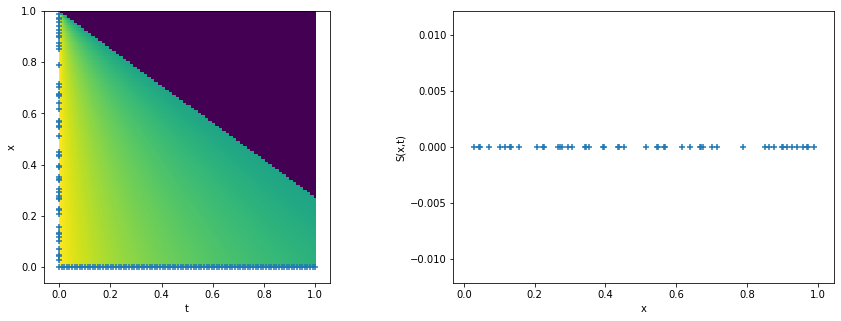

In [4]:
n_u = 0
n_boundary_t_0 = 50
idx_boundary_x_0 = 100
idx_boundary_x_1 = 0
idx_boundary_x_in = 0

data = scipy.io.loadmat(path_file)
t_data = data['t'].flatten()[:, None]
x_data = data['x'].flatten()[:, None]
u_actual = np.real(data['usol']).T
x_mesh, t_mesh = np.meshgrid(x_data, t_data)

data_dict = dict(x=x_mesh.flatten(), t=t_mesh.flatten(), u=u_actual.flatten())
df_data = pd.DataFrame(data_dict)

idx_in = pd.Index(np.random.choice(len(df_data), n_u, replace=False))
idx_in = pd.Index(np.random.choice(df_data[(np.abs(df_data.x-0.5) <= 1e-2)|(np.abs(df_data.x-0.2) <= 1e-2)|(np.abs(df_data.x-0.7) <= 1e-2)].index, idx_boundary_x_in, replace=False))
idx_boundary_t_0 = pd.Index(np.random.choice(df_data[np.abs(df_data.t - 0.0) <= 1e-2].index, n_boundary_t_0, replace=False))
idx_boundary_x_1 = pd.Index(np.random.choice(df_data[df_data.x == 1.0].index, idx_boundary_x_1, replace=False))
idx_boundary_x_0 = pd.Index(np.random.choice(df_data[df_data.x == 0.0].index, idx_boundary_x_0, replace=False))
idx_train = idx_boundary_t_0.append((idx_boundary_x_0, idx_boundary_x_1, idx_in))

idx_test = df_data.index.difference(idx_train)

u_train = df_data.u[idx_train].values[:,None]
x_train = df_data.x[idx_train].values[:,None]
t_train = df_data.t[idx_train].values[:,None]

u_test = df_data.u[idx_test].values[:,None]
x_test = df_data.x[idx_test].values[:,None]
t_test = df_data.t[idx_test].values[:,None]

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(df_data.u.values.reshape((100,256)),extent=[0,1,0,1])
axs[0].scatter(df_data.loc[idx_train, 't'], df_data.loc[idx_train, 'x'], marker="+")
axs[0].set(xlabel='t', ylabel='x')
axs[1].scatter(df_data.loc[idx_boundary_t_0, 'x'], df_data.loc[idx_boundary_t_0, 'u'], marker='+')
axs[1].set(xlabel='x', ylabel='S(x,t)')

### GAN Training

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter: 0,  discriminator: 1.4946,  generator: 0.6125,  entropy: -0.0784,  posterior: 0.3409,  pde: 0.3499


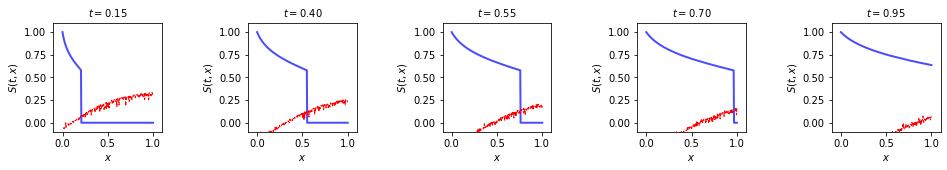

Iter: 1000,  discriminator: 1.3833,  generator: 0.0151,  entropy: 0.0115,  posterior: 0.0002,  pde: 0.0033
Iter: 2000,  discriminator: 1.3589,  generator: 0.0970,  entropy: -0.0256,  posterior: 0.0000,  pde: 0.1225
Iter: 3000,  discriminator: 1.3363,  generator: 0.2955,  entropy: 0.1140,  posterior: 0.0000,  pde: 0.1814
Iter: 4000,  discriminator: 1.3503,  generator: 0.2760,  entropy: 0.1200,  posterior: 0.0000,  pde: 0.1560
Iter: 5000,  discriminator: 1.3854,  generator: 0.0058,  entropy: -0.0266,  posterior: 0.0000,  pde: 0.0323


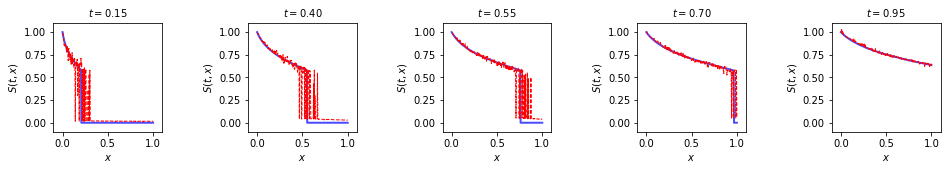

Iter: 6000,  discriminator: 1.3656,  generator: 0.0688,  entropy: 0.0426,  posterior: 0.0000,  pde: 0.0263
Iter: 7000,  discriminator: 1.3825,  generator: 0.0242,  entropy: 0.0180,  posterior: 0.0000,  pde: 0.0062
Iter: 8000,  discriminator: 1.3864,  generator: 0.0026,  entropy: 0.0008,  posterior: 0.0000,  pde: 0.0017
Iter: 9000,  discriminator: 1.3861,  generator: 0.0002,  entropy: -0.0010,  posterior: 0.0000,  pde: 0.0013
Iter: 10000,  discriminator: 1.3867,  generator: -0.0095,  entropy: -0.0103,  posterior: 0.0000,  pde: 0.0008


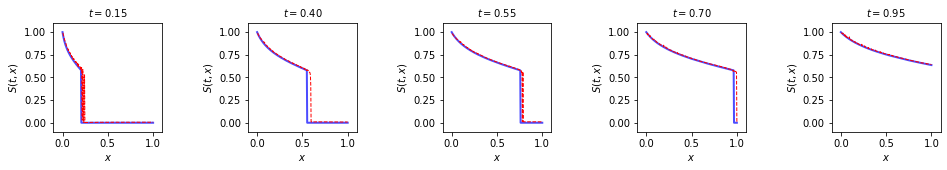

Iter: 11000,  discriminator: 1.3791,  generator: 0.0214,  entropy: 0.0192,  posterior: 0.0000,  pde: 0.0022
Iter: 12000,  discriminator: 1.3817,  generator: -0.0039,  entropy: -0.0058,  posterior: 0.0000,  pde: 0.0019
Iter: 13000,  discriminator: 1.3770,  generator: 0.0238,  entropy: 0.0208,  posterior: 0.0000,  pde: 0.0030
Iter: 14000,  discriminator: 1.3864,  generator: 0.0016,  entropy: 0.0000,  posterior: 0.0000,  pde: 0.0015
Iter: 15000,  discriminator: 1.3864,  generator: 0.0023,  entropy: 0.0016,  posterior: 0.0000,  pde: 0.0007


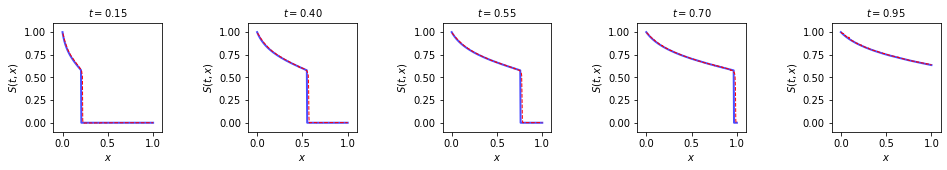

In [5]:
### GAN Trainingtf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 1], name='x')
t = tf.placeholder(tf.float32, [None, 1], name='t')

with tf.variable_scope('generator'):
    x_collocation = tf.placeholder(tf.float32, [None, 1], name='x_collocation')
    t_collocation = tf.placeholder(tf.float32, [None, 1], name='t_collocation')
    u_sample_collocation = tf.placeholder(tf.float32, [None, latent_var_nb], name='u_sample_collocation')
    u_sample = tf.placeholder(tf.float32, [None, latent_var_nb], name='u_sample')    
    mlp_config_generator = MLPConfig(layer_size_lst=gen_layer_lst,
                                     activation_lst=gen_activation_lst,
                                     main_name='generator')

    net_pde = create_mlp(tf.concat([x, t, u_sample], 1), mlp_config_generator)
    gen_pde = tf.concat([x, t, net_pde], axis=1, name='gen_pde')
    mlp_config_posterior = MLPConfig(layer_size_lst=pos_layer_lst, 
                                   activation_lst=pos_activation_lst, 
                                   main_name='posterior')
    logits_posterior = create_mlp(gen_pde, mlp_config_posterior)
    net_pde_collocation = create_mlp(tf.concat([x_collocation, t_collocation, u_sample_collocation], 1), mlp_config_generator, reuse=True)
    net_pde_residuals = net_pde_res_buckley(net_pde_collocation, x_collocation, t_collocation)# - 0.001*tf.gradients(net_pde_collocation,x_collocation)[0]
    
    
with tf.variable_scope('discriminator') as scope:
    u_real = tf.placeholder(tf.float32, [None, 1])
    mlp_config_discriminator = MLPConfig(layer_size_lst=dis_layer_lst, 
                                         activation_lst=dis_activation_lst, 
                                         main_name='discriminator')
    logits_real = create_mlp(tf.concat([x, t, u_real], 1), mlp_config_discriminator)
    scope.reuse_variables()
    logits_fake = create_mlp(gen_pde, mlp_config_discriminator)

dis_loss = discriminator_loss(logits_real, logits_fake)
gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde = generator_loss(logits_fake, logits_posterior, net_pde_residuals, w_posterior_loss, w_pde_loss)

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator")
dis_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="discriminator")
gen_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(gen_loss, var_list=gen_vars) # G Train step
dis_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(dis_loss, var_list=dis_vars) # D Train step

init = tf.global_variables_initializer()
model_saver = tf.train.Saver()

with tf.Session() as sess:        
    sess.run(init)
    for i in range(iter_nb):
        idx_batch = np.random.choice(u_train.shape[0], batch_size, replace=False)   
        u_real_batch = u_train[idx_batch, :]
        u_sample_batch = np.random.normal(size=(u_real_batch.shape[0], latent_var_nb))
        x_batch = x_train[idx_batch, :]
        t_batch = t_train[idx_batch, :]
        idx_batch_collocation = np.random.choice(u_test.shape[0], batch_size_collocation, replace=False)   
        x_collocation_batch = x_test[idx_batch_collocation, :]
        t_collocation_batch = t_test[idx_batch_collocation, :]
        u_sample_batch_collocation = np.random.normal(size=(x_collocation_batch.shape[0], latent_var_nb))
    
        for _ in range(dis_steps_nb):
            run_lst = [dis_minimize_step, dis_loss]
            feed_dict = {u_real: u_real_batch, u_sample: u_sample_batch, x: x_batch, t: t_batch, x_collocation: x_collocation_batch, t_collocation: t_collocation_batch, u_sample_collocation: u_sample_batch_collocation}
            _, d_loss = sess.run(run_lst, feed_dict=feed_dict)            

        for _ in range(gen_steps_nb):
            run_lst = [gen_minimize_step, gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde]
            feed_dict = feed_dict={u_sample: u_sample_batch,  x: x_batch, t: t_batch, x_collocation: x_collocation_batch, t_collocation: t_collocation_batch, u_sample_collocation: u_sample_batch_collocation}
            _, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde = sess.run(run_lst, feed_dict=feed_dict)
        
        if i==0:
            loss_array = np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])
        if i % 1000 == 0:
            print("Iter: %d,  discriminator: %.4f,  generator: %.4f,  entropy: %.4f,  posterior: %.4f,  pde: %.4f" % (i, d_loss, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde))
            loss_array = np.vstack((loss_array, np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])))

        if i % 5000 == 0:
            u_test_sample = np.random.normal(size=(u_test.shape[0], latent_var_nb))
            x_gen = sess.run(gen_pde, feed_dict={u_sample: u_test_sample, x: x_test, t: t_test, u_sample_collocation: u_sample_batch_collocation})
            u_pred = griddata(df_data.loc[idx_test,['x', 't']], x_gen[:,2].flatten(), (x_mesh, t_mesh), method='cubic')

            cut_lst = [15, 40, 55, 70, 95]
            fig = plt.figure(figsize=(16,2))
            ax = fig.add_subplot(111)
            ax.axis('off')
            plot_nb = len(cut_lst)
            gs0 = gridspec.GridSpec(1, plot_nb, wspace=0.7)
        
            for j in range(plot_nb):
                plot_cut_test(grid_spec=gs0[0,j], x=x_data, actual=u_actual, pred=u_pred, cut=cut_lst[j], x_lim=[-0.1,1.1], y_lim=[-0.1,1.1], ylabel='$S(t,x)$')

            plt.show()
    model_saver.save(sess, os.path.join(path_models, 'gan_buckley.ckpt'))

### 3D Actual vs Predicted 

In [ ]:
### 3D Actual vs Predicted from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

# Make plotly work with Jupyter notebook
init_notebook_mode()

pred = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = u_pred.flatten(),
    marker = go.Marker(color='red', size=1.5),
    mode = 'markers'
)

actual = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = df_data.u,
    marker = go.Marker(color='blue', size=1.5),
    mode = 'markers'
)

data = go.Data([pred, actual])

iplot(data)

### Loss Functions

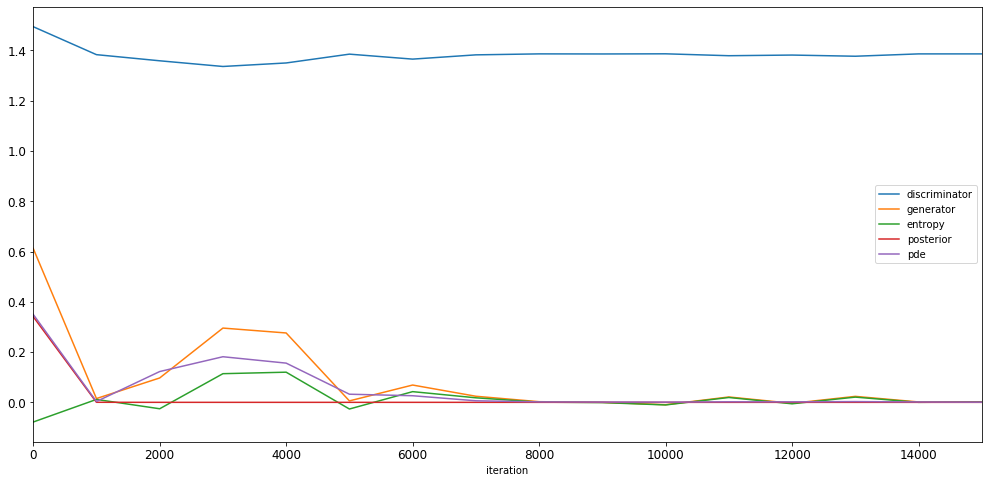

In [6]:
df_loss = pd.DataFrame(loss_array, columns=['iteration', 'discriminator', 'generator', 'entropy', 'posterior', 'pde'])
# df.plot(x=df.iteration, y=df.columns[1:], figsize=(17,8), fontsize=12)
df_loss.iteration = df_loss.iteration.astype(int)
df_loss.set_index(df_loss.iteration, inplace=True)
df_loss.drop(['iteration'], axis=1, inplace=True)
df_loss.plot(figsize=(17,8), fontsize=12)